### Regime Classification: Long-Term US Bonds
This notebook explores the application of machine learning to predict long-term bond regimes and use estimated transition probabilities to create long/short positions. First, the machine learning model used is the random forest classifier. This model builds multiple decision trees and aggregates individual predictions into a single classification. It uses ***bagging*** and ***bootstrapping*** to ensure trees are uncorrelated, making the model robust and less prone to overfitting. Secondly, a ***regime*** is defined as a period of distinct market conditions. I use a bull regime to denote a period of positive returns and a bear regime to denote a period of negative returns. The distinction of regimes comes from the historical return distribution's quantiles.


Long-term US (treasury) bonds are debt instruments issued by the US government. Upon issuance, the governemnt offers periodic coupon payments along with the repayment of principal upon expiration. While US bonds are considered "risk-free" in principal, they are not "risk-free" in price. Bond prices are affected by a multitude of factors (expected growth, expected inflation, US government credit ratings, ect. just to name a few). Becasue US bonds are risky in price and exhibit long-term trends, there exists an opportunity to predict its regimes using factors that drive interest rates (thus price). Bond markets exhibit macro trends due to business and interest rate cycles. Using these common factors, I beleive that machine learning models can capture the relationship between long-term bond prices and these macro and technical features. Even with a slight prediction edge (over 50% accuracy), prediction models can harvest returns greater than the general market index. TLT (20+ year US treasury ETF) will be the proxy for the long-term US bond market.

In [21]:
# Notebook Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# RF Classifier
from sklearn.ensemble import RandomForestClassifier

# Classification metrics
from sklearn.metrics import classification_report

# Notebook Settings
plt.style.use('seaborn-v0_8')

In [22]:
# Window parameters
HORIZON_1m = 21  # 1 trading month
HORIZON_1y = 252 # 1 trading year

# Parameters
SYMBOL = 'TLT'

# Data files
# NOTE: This is pre-cleaned data
DATA_FILE    = 'data/feature_data.csv'
FEATURE_FILE = 'data/features.csv'

The data was downloaded from a private script, although the source of the data is from Yahoo Finance and FRED.

In [23]:
# Extract data
data = pd.read_csv(DATA_FILE)

data = data.rename(columns={'Unnamed: 0' : 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

The features idnetified were from a private feature engineering script. The feature engineering process was as follows:
- Compute correlations among features
- Remove highly correlated features (keeping the feature with the highest model importance)
- Compute temporal stability with SHAP
- Keep the uncorrelated features with the highest temporal stability

In [24]:
# Extract feature names
feature_names = pd.read_csv(FEATURE_FILE)['Unnamed: 0'].to_list()

In [25]:
# Construct the regimes
states = ['bear', 'bull']
n_q = len(states)

data['return_1m'] = data[SYMBOL].pct_change(HORIZON_1m).shift(-HORIZON_1m)
data['future_regime'] = pd.qcut(data['return_1m'], q=n_q, labels=states)

In [26]:
# Features and response
X = data[feature_names]
y = data['future_regime']

# Clean data
X = X.replace([np.inf, -np.inf], np.nan)

In [27]:
# Store predictions
preds = []
true  = []
dates = []

rets = []

horizon = HORIZON_1m
train_window = HORIZON_1y * 5 # 5 Years

# NOTE: Stopping at len(data)-horizon because we will not know performance past then
# NOTE: This is for practical purposes ONLY (we would not have the returns or the
#       values to asses model accuracy)
for t in tqdm(range(train_window + horizon, len(data)-horizon, horizon)):
    # Train and test set windows
    train_start = t - train_window - horizon
    train_end   = t - horizon
    test_start  = train_end
    test_end    = t

    # Split train and test data
    # NOTE: Excludes day t (no lookahead bias)
    X_train, y_train = X.iloc[train_start:train_end], y.iloc[train_start:train_end]
    X_test, y_test = X.iloc[test_start:test_end], y.iloc[test_start:test_end]

    # NOTE: The model has optimized parameters
    #       (seperate study)
    model = RandomForestClassifier(
        n_estimators = 300,
        max_depth = 10,
        min_samples_leaf = 0.02,
        min_samples_split = 0.001,
        random_state = 42,
        max_features = 'sqrt',
        class_weight='balanced_subsample'
    )
    model.fit(X_train, y_train)

    # Create the transition matrix
    states = y_train.unique()
    transition_counts = pd.DataFrame(0, index=states, columns=states)
    for i in range(len(y_train)-1):
        transition_counts.loc[y_train.iloc[i], y_train.iloc[i+1]] += 1

    P = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

    # Predict next period's regime
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)[-1]   # last observation in test window
    pred_states = model.classes_
    prob_vec = pd.Series(probs, index=pred_states)

    adj_probs = prob_vec @ P.loc[pred_states, pred_states]

    mapping = {'bull': 1, 'bear': -1}
    exp_pos = sum(adj_probs[state] * mapping[state] for state in mapping)

    # Monthly returns
    # NOTE: Data was shifted so r_t is next months return
    rets.append(exp_pos * data['return_1m'].iloc[t])

    # Store results
    preds.extend(y_pred)
    true.extend(y_test)
    dates.append(data.index[t])

# Performance data frames
model_results = pd.DataFrame({
    'y_true': true,
    'y_pred': preds
})

100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


In [ ]:
# Evaluate overall regimed classification performance
# NOTE: This is not strategy performance
print('Classification Report:')
print(classification_report(model_results['y_true'], model_results['y_pred']))

Classification Report:
              precision    recall  f1-score   support

        bear       0.66      0.65      0.65      2190
        bull       0.62      0.64      0.63      2010

    accuracy                           0.64      4200
   macro avg       0.64      0.64      0.64      4200
weighted avg       0.64      0.64      0.64      4200



Sharpe: 1.2156882390560289
CAGR:   0.032664866303203866
Vola.:  0.04723986773200466


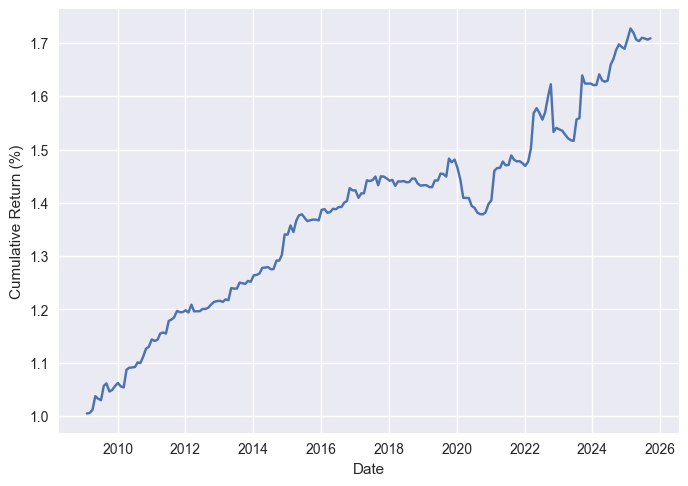

In [29]:
# Strategy performance
strategy_results = pd.DataFrame({
    'dates' : dates,
    'rets' : rets
}).set_index('dates')

strategy_results['cumulative_rets'] = (1 + strategy_results['rets']).cumprod()

sharpe = (strategy_results['rets'].mean() / strategy_results['rets'].std()) * np.sqrt(HORIZON_1m)
cagr = (strategy_results['cumulative_rets'].iloc[-1]) ** (HORIZON_1y / (len(strategy_results) * HORIZON_1m)) - 1
vola = strategy_results['rets'].std() * np.sqrt(HORIZON_1m)

print(f'Sharpe: {sharpe}')
print(f'CAGR:   {cagr}')
print(f'Vola.:  {vola}')

plt.plot(strategy_results['cumulative_rets'])
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.show()